# Histopathologic Cancer Detection Project

University of Colorado Boulder

DTSA 5511 Week 5

## 1. Introduction 

This notebook tackles the Histopathologic Cancer Detection challenge, where the goal is to indentify metastatic cancer in images and classify cancerous and non-cancerous cells based on small 32x32px patches in a larger 96x96 pixel image dataset.

I aim to develop and compare two convolutional neural network (CNN) architectures. The first will be a baseline CNN with standard convolutional, pooling, and dense layers. The second architecture will introduce batch normalization to improve peformance and compare how the model performs when the layer activations are normalized. In theory, the batch normalization will help the model focus on the most important patterns needed to recognize cancer while being able to essentially ignore the variation in cell-staining intensity and color birghtness in the images, resulting in higher accuracy.

### 1.1 Problem Statement

Metastatic cancer detection from pathology scans is critical to cancer diagnosis. This project attempts to develop a more efficient way for pathologists to identify metastatic cells than the time-consuming and error-prone method of manually reviewing slides.

The task is a binary image classification problem with inputs of small image patches from larger pathology scans and outputs of binary predictions (0 or 1) indicating the presence of tumor tissue. A label of 0 is negative for cancer, while a label of 1 is positive for cancer.

### 1.2 Data Description

The dataset is a modified version of the PatchCamelyon (PCam) benchmark dataset where images are small patches taken from histopathology scans. In this dataset, a positive label (1) indicates that the center 32x32px region contains at least one pixel of tumor tissue. The outer region provides context for models that don't use zero-padding, and tumor tissue in the outer region does not influence the label. It is important to note that this dataset does not contain duplicate images, which differs from the original PatchCamelyon dataset.

## 2. Setup

Note: I decided not to use the accelerator T4s because my implementation of ImageDataGenerator was not optimized for parallelization, which resulted in low GPU usage (<5%). Being that this is a homework assignment, the optimization is not super important initially, but I would like to revisit this and refactor some things. The time spent setting up the compute ended up not being worth the time saved, but I kept it in this notebook in case someone (possibly me) would like to improve it. Also, it serves as a good reference for later use. Can I make this text smaller?

In [1]:
# Basic Imports
import os
import numpy as np
import pandas as pd

# Plotting Tools
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks

# sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
# setting random seed for use throughout the notebook
RANDOM_SEED = 19
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
# check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")

Num GPUs Available: 0


In [4]:
# set up strategy for use with two NVIDIA T4s, if available
if gpus:

    # configure memory growth to avoid memory allocation issues
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # setup MirroredStrategy on the T4s
    strategy = tf.distribute.MirroredStrategy()
    print(f"Using MirroredStrategy with {strategy.num_replicas_in_sync} T4 GPUs")
    
    # enable mixed precision for optimzied training
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

else: # use defaults
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
    print("No GPUs available, using Kaggle standard CPU")
    tf.keras.mixed_precision.set_global_policy('float32')

No GPUs available, using Kaggle standard CPU


In [5]:
# load data
TRAIN_DIR = '/kaggle/input/histopathologic-cancer-detection/train/'
TEST_DIR = '/kaggle/input/histopathologic-cancer-detection/test/'
TRAIN_LABELS_PATH = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

train_labels = pd.read_csv(TRAIN_LABELS_PATH)
print(f"Training labels shape: {train_labels.shape}")
print(train_labels.head())

Training labels shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [6]:
# check class distribution
class_distribution = train_labels['label'].value_counts(normalize=True) * 100
print(f"\nClass distribution (%):\n{class_distribution}")


Class distribution (%):
label
0    59.496875
1    40.503125
Name: proportion, dtype: float64


## 3. EDA

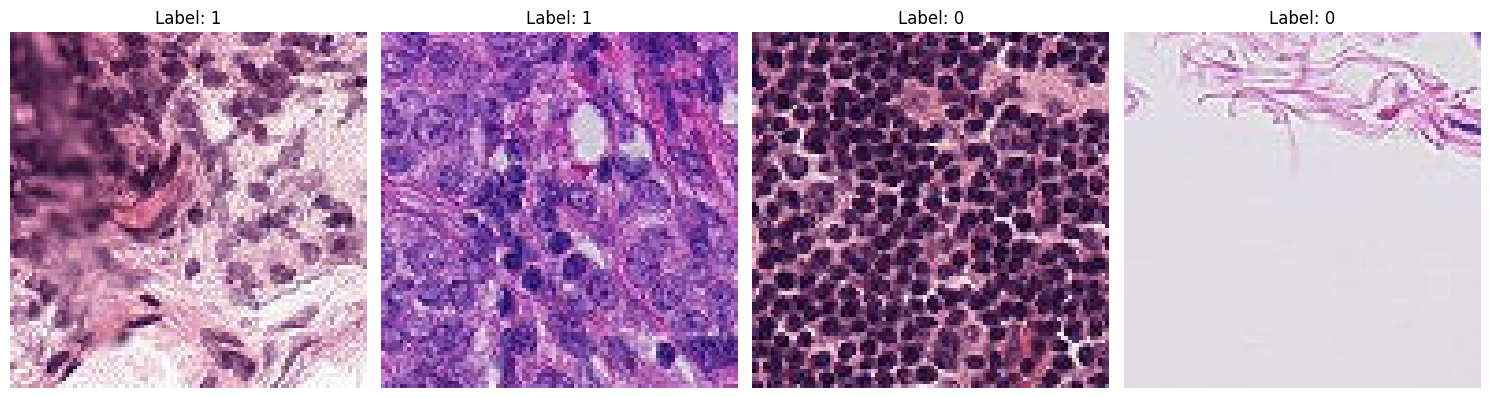

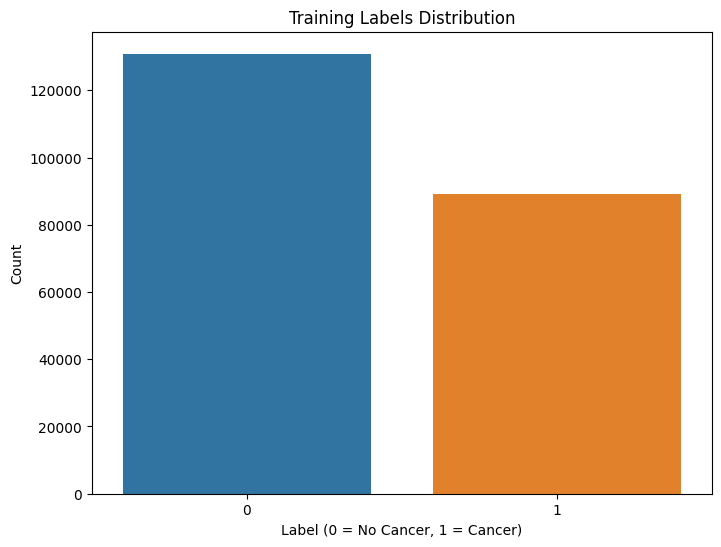

In [8]:
# sample images from each class
pos_samples = train_labels[train_labels['label'] == 1].sample(2)
neg_samples = train_labels[train_labels['label'] == 0].sample(2)
sample_df = pd.concat([pos_samples, neg_samples])

# add file extension to path & convert to string for Keras
sample_df['filename'] = sample_df['id'] + '.tif'
sample_df['label_str'] = sample_df['label'].astype(str)

# plot images
plt.figure(figsize=(15, 8))
for i, (_, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(TRAIN_DIR, row['filename'])
    img = plt.imread(img_path)/255   
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Label: {row['label']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# plot dist
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Training Labels Distribution')
plt.xlabel('Label (0 = No Cancer, 1 = Cancer)')
plt.ylabel('Count')
plt.show()

### EDA Results
The data exhibits a class imbalance of 59.5% negative to 40.5% positive for cancer. I do not believe that this is a significant class imbalance that warrants up or down sampling for this task. All images have standard dimensions, but from a cursory view of some samples, the variation in color and amount of nonnegative space varies wildly.

## 4. Preprocessing

In [8]:
train_data = train_labels.copy() # uncomment for full run

# add file extension to path & convert to string for Keras
train_data['filename'] = train_data['id'] + '.tif'
train_data['label_str'] = train_data['label'].astype(str)

In [9]:
# set batch size to match strategy
if gpus:
    replicas = strategy.num_replicas_in_sync
    BATCH_SIZE = 128 * replicas # should be fine
    print(f"Using batch size of {BATCH_SIZE} with {replicas} GPU(s)")
else:
    BATCH_SIZE = 64
    print(f"Using default batch size of {BATCH_SIZE}")

# size of the images
IMG_SIZE = (32, 32)

Using default batch size of 64


In [10]:
def extract_center(img):
    # center coordinates
    h, w = img.shape[0], img.shape[1]
    center_h, center_w = h // 2, w // 2
    offset = 16  # 32/2 pixels
    
    # get center 32x32 region
    center_img = img[center_h-offset:center_h+offset, center_w-offset:center_w+offset, :]
    return center_img

Extracting the center 32x32 pixels removes context of the larger image, but improves training time by quite a bit. 

In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=extract_center,
    validation_split=0.2
)

In [17]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

print(f"Training generator batches: {len(train_generator)}")

Found 176020 validated image filenames belonging to 2 classes.
Training generator batches: 2751


In [21]:
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


print(f"Validation generator batches: {len(validation_generator)}")

Found 44005 validated image filenames belonging to 2 classes.
Validation generator batches: 688


In [19]:
# calculate steps for training
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 2751
Validation steps: 688


## 5. Model Development - Base CNN

Base architecture with 2 convolutional blocks, relu activation function, consistent padding, and possibility for more efficient training with parallelized strategy on NVIDIA T4s.

In [14]:
with strategy.scope():
    def create_baseline_model():
        model = models.Sequential([
            
            # 1st convolutional block
            layers.Input(shape=(32, 32, 3)),
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # 2nd convolutional block
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # 3rd convolutional block
            layers.Conv2D(256, (3, 3), padding='same'),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # flatten and dense layers
            layers.Flatten(),
            layers.Dense(256),
            layers.Activation('relu'),
            layers.Dropout(0.5),
            
            layers.Dense(1, activation='sigmoid', dtype='float32')
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )
        
        return model
    
    baseline_model = create_baseline_model()
    baseline_model.name = "Baseline"  

print("Baseline CNN Model Summary:")
baseline_model.summary()

Baseline CNN Model Summary:


Model: "Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,419,905 (5.42 MB)

 Trainable params: 1,419,905 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Development - CNN with Batch Normalization

"Experimental" architecture with the same architecture as the baseline model but added batch normalization to allow improved learning, overfitting reduction, and mitigating possible weighting imbalances due to color intensity in the images.

In [15]:
with strategy.scope():
    def create_batchnorm_model():
        model = models.Sequential([
            
            # 1st convolutional block with batch normalization
            layers.Input(shape=(32, 32, 3)),
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # 2nd convolutional block with batch normalization
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # 3rd convolutional block with batch normalization
            layers.Conv2D(256, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # flatten and dense layers
            layers.Flatten(),
            layers.Dense(256),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.5),

            layers.Dense(1, activation='sigmoid', dtype='float32')  
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )
        
        return model
    
    batchnorm_model = create_batchnorm_model()
    batchnorm_model.name = "BatchNorm"  

print("BatchNorm CNN Model Summary:")
batchnorm_model.summary()

BatchNorm CNN Model Summary:


Model: "BatchNorm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,422,721 (5.43 MB)

 Trainable params: 1,421,313 (5.42 MB)

 Non-trainable params: 1,408 (5.50 KB)

## 7. Model Training and Evaluation

In [ ]:
# callbacks 
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_baseline_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# callbacks for the BatchNorm model
batchnorm_callbacks = callbacks_list.copy()

# ModelCheckpoint for BatchNorm
batchnorm_callbacks[-1] = callbacks.ModelCheckpoint(
    filepath='best_batchnorm_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [27]:
# train baseline model 
print("\nTraining Baseline CNN Model...")
baseline_history = baseline_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=1
)


Training Baseline CNN Model...
Epoch 1/10
2750/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7734 - loss: 0.4810
Epoch 1: val_accuracy improved from -inf to 0.82426, saving model to best_baseline_model.keras
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1279s 464ms/step - accuracy: 0.7734 - loss: 0.4810 - val_accuracy: 0.8243 - val_loss: 0.3839 - learning_rate: 0.0010
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8301 - loss: 0.3829
Epoch 2: val_accuracy improved from 0.82426 to 0.83976, saving model to best_baseline_model.keras
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 938s 340ms/step - accuracy: 0.8301 - loss: 0.3829 - val_accuracy: 0.8398 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.83976
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 84s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8398 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8468 - loss: 0

In [20]:
# train batch normalization model
print("\nTraining BatchNorm CNN Model...")
batchnorm_history = batchnorm_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=batchnorm_callbacks,
    verbose=1
)


Training BatchNorm CNN Model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2750/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8115 - loss: 0.4275

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.84984, saving model to best_batchnorm_model.keras
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1903s 691ms/step - accuracy: 0.8116 - loss: 0.4275 - val_accuracy: 0.8498 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8640 - loss: 0.3195
Epoch 2: val_accuracy did not improve from 0.84984
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 789s 286ms/step - accuracy: 0.8640 - loss: 0.3195 - val_accuracy: 0.7689 - val_loss: 0.7459 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.84984
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 74s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7689 - val_loss: 0.7459 - learning_rate: 0.0010
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8812 - loss: 0.2853
Epoch 4: val_accuracy did not improve from 0.84984
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 748s 272ms/step - accuracy: 0.8812 - loss: 0.2853 - val_accuracy: 0.7751 - val_

## 8. Results Comparison

In [22]:
# load models & evaluate on validation data
baseline_model = tf.keras.models.load_model('/kaggle/working/best_baseline_model.keras')
batchnorm_model = tf.keras.models.load_model('/kaggle/working/best_batchnorm_model.keras')

baseline_results = baseline_model.evaluate(validation_generator, verbose=1)
batchnorm_results = batchnorm_model.evaluate(validation_generator, verbose=1)

metric_names = baseline_model.metrics_names
metric_names[1] = 'accuracy'

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


688/688 ━━━━━━━━━━━━━━━━━━━━ 347s 504ms/step - accuracy: 0.8535 - loss: 0.3353
688/688 ━━━━━━━━━━━━━━━━━━━━ 85s 122ms/step - accuracy: 0.9097 - loss: 0.2249


In [23]:
# vizz
def visualize_model_performance(model, generator, results):
        
    generator.reset()
    prediction_batch_size = BATCH_SIZE * 2
    prediction_steps = (generator.samples + prediction_batch_size - 1) // prediction_batch_size
    
    # new generator with larger batch size for prediction
    temp_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=TRAIN_DIR,
        x_col='filename',
        y_col='label_str',
        target_size=IMG_SIZE,
        batch_size=prediction_batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )
    
    # predict
    y_pred = model.predict(temp_generator, steps=prediction_steps, verbose=1)
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    
    # get labels
    y_true = generator.classes[:len(y_pred_classes)]
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Non-tumor', 'Tumor'],
        yticklabels=['Non-tumor', 'Tumor']
    )
    plt.title(f'Confusion Matrix - {model.name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # ROC AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model.name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes))
    
    return roc_auc

Found 44005 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 85s 246ms/step


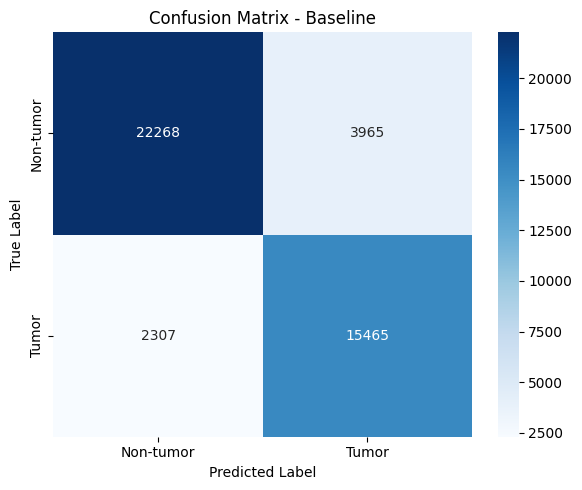

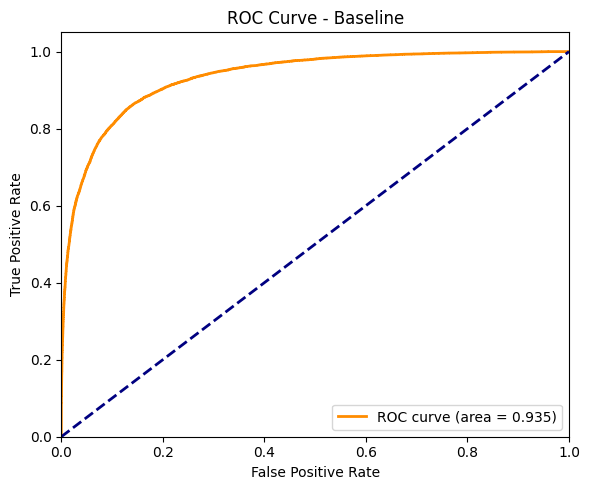


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     26233
           1       0.80      0.87      0.83     17772

    accuracy                           0.86     44005
   macro avg       0.85      0.86      0.85     44005
weighted avg       0.86      0.86      0.86     44005

Found 44005 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step


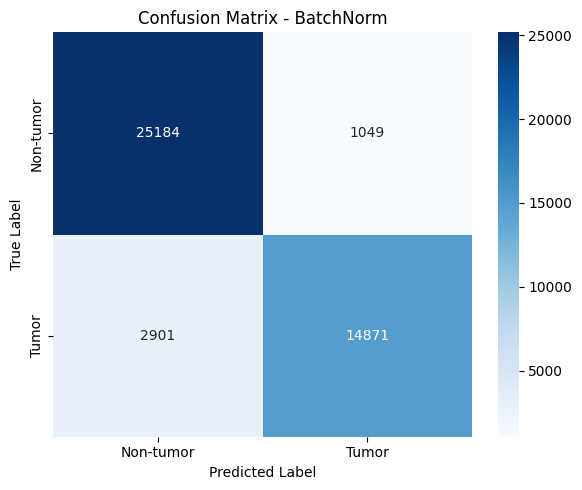

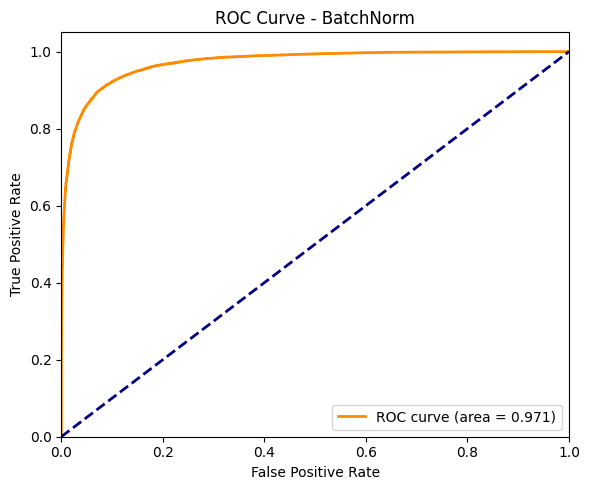


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     26233
           1       0.93      0.84      0.88     17772

    accuracy                           0.91     44005
   macro avg       0.92      0.90      0.91     44005
weighted avg       0.91      0.91      0.91     44005



In [26]:
# Get additional metrics (AUC)
baseline_auc = visualize_model_performance(baseline_model, validation_generator, baseline_results)
batchnorm_auc = visualize_model_performance(batchnorm_model, validation_generator, batchnorm_results)

From the results, the batch norm model performs much better. Something that stood out to me was the difference in false positive rate between the models as shown in the ROC curve and the confusion matrix. The batch norm model classified more false negatives and fewer false positives than the baseline model. This may not be the best for medical applications with dire consequences for misdiagnoses.

In [27]:
# results table
comparison_df = pd.DataFrame({
    'Model': ['Baseline CNN', 'BatchNorm CNN'],
    'Validation Loss': [baseline_results[0], batchnorm_results[0]],
    'Validation Accuracy': [baseline_results[1], batchnorm_results[1]],
    #'AUC': [baseline_results[2], batchnorm_results[2]],
    'AUC': [baseline_auc, batchnorm_auc]
})

print("\nModel Performance Comparison:")
print(comparison_df)


Model Performance Comparison:
           Model  Validation Loss  Validation Accuracy       AUC
0   Baseline CNN         0.328569             0.857471  0.934535
1  BatchNorm CNN         0.221343             0.910237  0.971152


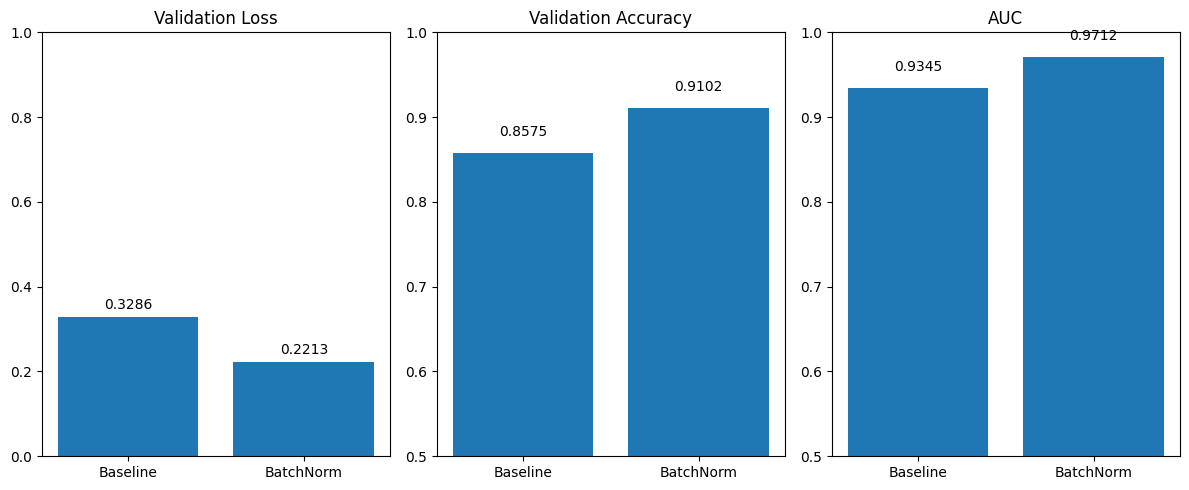

In [28]:
# compare metrics
metrics = ['Validation Loss', 'Validation Accuracy', 'AUC']
plt.figure(figsize=(12, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(['Baseline', 'BatchNorm'], comparison_df[metric])
    plt.title(metric)
    plt.ylim(0 if metric == 'Validation Loss' else 0.5, 1.0)
    
    for j, v in enumerate(comparison_df[metric]):
        plt.text(j, v + 0.02, f"{v}", ha='center')

plt.tight_layout()
plt.show()

Validation loss, validation accuracy, and AUC are all improved from the baseline model when batch normalization is introduced. However, the confusion matrices above show an increase in problematic false negatives. The trade off is more correctly classified images overall.

## 9. Submission

In [29]:
if baseline_results[1] > batchnorm_results[1]:
    best_model = baseline_model
    print(f"Using Baseline model for submission (accuracy: {baseline_results[1]})")
else:
    best_model = batchnorm_model
    print(f"Using BatchNorm model for submission (accuracy: {batchnorm_results[1]})")

Using BatchNorm model for submission (accuracy: 0.9102374911308289)


In [30]:
# test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# test file names DF
test_files = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'id': [os.path.splitext(file)[0] for file in test_files],
    'filename': test_files
})

In [31]:
# make test data gen
submission_batch_size = BATCH_SIZE * 2 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col='filename',
    y_col=None,  # no labels for test data
    target_size=IMG_SIZE,
    batch_size=submission_batch_size,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [32]:
# predict
print("\nGenerating predictions for submission...")
predictions = best_model.predict(
    test_generator,
    verbose=1
)
predicted_classes = (predictions > 0.5).astype(int).flatten()


Generating predictions for submission...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 378s 843ms/step


In [33]:
# save
submission_df = pd.DataFrame({
    'id': test_df['id'][:len(predicted_classes)],
    'label': predicted_classes
})

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")
print(f"Sample of submission file:\n{submission_df.head()}")

Submission saved to submission.csv
Sample of submission file:
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


## 10. Conclusion and Future Directions

### Summary
In this project, I completed the challenge of detecting metastatic cancer by developing convolutional neural networks that learn from the center 32x32 pixels of larger 96x96 pixel histopathology scans. The core focus was to compare an simple architecture with standard convolutional, pooling, and dense layers to the same architecture with batch normalization added after each convolutional and dense layer.

### Results
Comparing that architectures revealed interesting results. The batchnorm model achieved higher final validation accuracy of 0.91 compared to the baseline model's 0.85 accuracy. Additionally, the architecture with batch normalization achieved a higher AUC (0.97) than the baseline model (0.93). Both models successfully learned to distinguish between cancerous cells with great accuracy.

These results confirm the theoretical advantages of batch normalization in medical imaging tasks. By normalizing activations within each batch, the model better handled the variation in tissue staining and color intensity.

### Significance
The results from this project exhibit that simple modifications to model architecture can significantly improve performance in classification tasks, at least in this type task using medical imaging.

### Future Work
In future work, various model improvements may be attempted such as implementing data augmentation that does not lose information from the center 32x32 pixel region to improve generalization of the model and trying different activation functions. Moreover, it is possibly worthwhile to develop explainable AI methods to assists in understanding model decisions by marking the model's areas of attention.


If you made it this far, I appreciate constructive input!